# Model Building: Iteration 4<br/>*Categorical Encoding*

## Goals
1. Determine which string variables may be helpful
2. Encode these variables
3. Evaluate and compare with previous model run

## Categorical Encoding and Avoiding Data Leakage
Encoding of Categorical variables can be performed on the entire data set up front.

Domain knowledge usually determines what distinct values a particular categorical variable can have. This knowledge is independent of any test set, so data leakage is (usually) not a concern.

## Categorical Encoding
There are three primary questions to ask:
1. Are the categorical values ordered?
2. Are there a large number of distinct values?
3. Are all values known in advance?

### Categorical Ordered
If the categorical value has an inherent ordering, then converting the sorted values to consecutive integers is a good approach.  The Titanic data came with this encoding for 1st-Class, 2nd-Class, and 3rd-Class already performed.

### Categorical Unordered: One Hot Encoding
A categorical variable with n distinct values will be converted to n dummy variables.  For each row, exactly one dummy variable will be 1 and the rest will be zero.

For example, "Male", "Female" would be encoded as follows: 
* "Female" -> is_female = 1, is_male = 0
* "Male" -> is_female = 0, is_male = 1

### Multicollinearity
Some estimators, such as Linear Regression and Logistic Regression, have unstable solutions if their input variables are linear combinations of one another.  These solutions become stable if regularization is used.

By default, Scikit Learn's LogisticRegression uses regulariation but its LinearRegression estimator does not.  In Scikit Learn, the regularized versions of LinearRegression are the Lasso, Ridge, and ElasticNet.

Encoding a categorical variable with n levels into n dummy variables means one variable is a linear combination of the others.  This is easiest to see when there are two levels.  If Sex can only have two mutually exclusive values, and is encoded as two dummy variables, such as is_male and is_female, then knowing one means knowing the other.  Instead, Sex can be encoded into a single variable, such as is_female.

ScitKit Learn's OneHotEncoder, as of May 2019 v0.21, now allows for reducing the number of dummy variables generated by one.  This is important if LinearRegression is to be used as the estimator (or LogisticRegression is used without regularization).

Pandas offers a method similar to OneHotEncoder, pd.get_dummies(), which also allows for the option of creating one less dummy variable to avoid multicollinearity.

Here, LogisticRegression is being used *with regularization*, so it is optional whether or not to include the extra dummy variable.  Depending on how you interpret the model, having the extra dummy variable will make it either more, or less, interpretable.  Below, the extra dummy variable is included. 

### Categorical Unordered: Large Number of Distinct Values
For each distinct value, a dummy variable will be created.  If there are a large number of distinct values, many dummy variables will be created.  The more dummy variables, the higher the dimension and the more likely that "the curse of dimensionality" becomes a problem.  Some estimators, such as KNN, do not work well with a high number of dimensions.

One option is to exclude a categorical variable with a large number of distinct values from the model.

Another option is to reduce the number of distinct values. Some ways this could be done include:
* have a domain expert re-categorize the values into a smaller number of categories
* automatically map all rare values into a single category

### Categorical: All Values not Known Up Front
One solution is to encode all values never seen before, into a single value or single dummy variable.

## Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.2
Description:	Ubuntu 18.04.2 LTS


In [3]:
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [4]:
# explictly enable and import new iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [5]:
# read in Titanic data
all_data = pd.read_csv('./data/train.csv')
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']
print('X Shape: ', X.shape)
print('y Shape: ', y.shape)

X Shape:  (891, 11)
y Shape:  (891,)


### Number of Distinct Values

In [6]:
print('Number of records: ', len(X))
print('\nNumber of Distinct Values')
print(f'PassengerId: {X["PassengerId"].nunique():3d}')
print(f'Name:        {X["Name"].nunique():3d}')      
print(f'Ticket:      {X["Ticket"].nunique():3d}')
print(f'Cabin:       {X["Cabin"].nunique():3d}')      
print(f'Embarked:    {X["Embarked"].nunique():3d}')

Number of records:  891

Number of Distinct Values
PassengerId: 891
Name:        891
Ticket:      681
Cabin:       147
Embarked:      3


* Every PassengerId is unique, so this carries no information.
* Every Name is unique, so this carries no information (as is).
* Most Ticket values are unique, so this carries very little information.

PassengerId, Name, and Ticket will not be used as is.

As per the EDA notebook, title can be extracted from the Name field.

title and Embarked will be encoded as dummy variables and added to the model.

### Number of Null Values

In [7]:
X['Embarked'].isna().sum()

2

The two null records, given that 3 dummy variables will be generated, will be encoded as all zeros.

In [8]:
# From EDA notebook
def extract_title(x):
    title = x.split(',')[1].split('.')[0].strip()
    if title not in ['Mr', 'Miss', 'Mrs', 'Master']:
        title = 'Other'
    return title

In [9]:
X['title'] = X['Name'].apply(extract_title)
X['title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: title, dtype: int64

In [10]:
# Embarked has 3 distinct values
X['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Encoding title and Embarked into Dummy Variables

Only three lines of code are required to encode Embarked and title as dummy variables.  The rest of this code is from previous notebooks.

Null values are encoded as all dummy variables having the value of 0.  There are two records with null Embarked values.

In [11]:
# Copied from titanic_helper_code.py
def get_Xy_v4(filename='./data/train.csv'):
    """Data Encoding for Iteration 4

    Version 4
    * Pclass, Fare, and Sex encoded as 1/0 for female/male
    * SibSp, Parch
    * family_size, is_cabin_notnull, is_large_family
    * is_child, is_boy, is_sibsp_zero, is_parch_zero
    * extract Title and dummy encode it
    * dummy encode Embarked
    """

    def extract_title(x):
        title = x.split(',')[1].split('.')[0].strip()
        if title not in ['Mr', 'Miss', 'Mrs', 'Master']:
            title = 'Other'
        return title
    
    # read data
    all_data = pd.read_csv('./data/train.csv')
    X = all_data.drop('Survived', axis=1)
    y = all_data['Survived']

    # encode data
    X['Sex'] = X['Sex'].replace({'female': 1, 'male': 0})
    X['family_size'] = X['SibSp'] + X['Parch'] + 1
    X['is_cabin_notnull'] = X['Cabin'].notnull()
    X['is_large_family'] = (X['family_size'] > 4)
    X['is_sibsp_zero'] = (X['SibSp'] == 0)
    X['is_parch_zero'] = (X['Parch'] == 0)

    # comparison with null is false
    # so is_child and is_boy are false when age is null
    X['is_child'] = (X['Age'] < 18)
    X['is_boy'] = (X['Age'] < 18) & (X['Sex'] == 0)

    # dummy encode title and Embarked
    X['title'] = X['Name'].apply(extract_title)
    dummy_title = pd.get_dummies(X['title'], prefix='Title')
    dummy_embarked = pd.get_dummies(X['Embarked'], prefix='Port')
    X = pd.concat([X, dummy_embarked, dummy_title], axis=1)

    # drop unused columns
    drop_columns = ['PassengerId', 'Name', 'title',
                    'Ticket', 'Embarked', 'Cabin']
    X = X.drop(drop_columns, axis=1)
    
    return X, y

In [12]:
X, y = tt.get_Xy_v4()
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'family_size',
       'is_cabin_notnull', 'is_large_family', 'is_sibsp_zero', 'is_parch_zero',
       'is_child', 'is_boy', 'Port_C', 'Port_Q', 'Port_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other'],
      dtype='object')

In [13]:
# Copied from titanic_helper_code.py
def get_ct_v3():
    """Column Transform for Features

    Version 3
    * with Categorical Variable Encoding
    * uses all columns for Wrapped IterativeImputer

    Returns column names and ColumnTransform instance.
    """

    ss = StandardScaler()
    ii = WrappedIterativeImputer('Age')
    kbin = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')

    # Pipelines
    ss_pipe = Pipeline([('ss', ss)])
    ii_ss_pipe = Pipeline([('ii', ii), ('ss', ss)])
    kbin_pipe = Pipeline([('kbin', kbin)])

    # Columns to act on
    ss_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'family_size']
    ii_ss_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'family_size',
                  'is_cabin_notnull', 'is_large_family', 'is_child', 'is_sibsp_zero',
                  'is_parch_zero', 'is_boy', 'Port_C', 'Port_Q', 'Port_S', 
                  'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']
    kbin_cols = ['Fare']
    bool_cols = ['Sex', 'is_cabin_notnull', 'is_large_family', 'is_child', 
                 'is_sibsp_zero', 'is_parch_zero', 'is_boy',
                 'Port_C', 'Port_Q', 'Port_S', 'Title_Master',
                 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    transformers = [('ss_tr', ss_pipe, ss_cols),
                    ('ii_ss_tr', ii_ss_pipe, ii_ss_cols),
                    ('kbin_tr', kbin_pipe, kbin_cols),
                    ('as_is', 'passthrough', bool_cols)]

    ct = ColumnTransformer(transformers=transformers, n_jobs=-1)

    # there is no way to access the columns by name from a pipe
    # create a list of columns to keep track
    cols = ss_cols + ['Age'] + ['is_fare_high'] + bool_cols

    return cols, ct

In [14]:
# CV for model comparison, not model selection
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)

In [15]:
X, y = tt.get_Xy_v4()
cols, ct = tt.get_ct_v3()

lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.811 max:0.848
CV Mean Score: 0.826 +/- 0.012


The scores have improved by adding Embarked and title.

At this point, Age is being imputed from all the variables, however Pclass, Sex and Title have the most direct relationship to age (this analysis is not shown here).  In the next ColumnTransformer, use only these variables for Age imputation.

In [16]:
# Copied from titanic_helper_code.py
def get_ct_v4():
    """Column Transform for Features

    Version 4
    * with Categorical Variable Encoding
    * use subset of variables for Wrapped IterativeImputer

    Returns column names and ColumnTransform instance.
    """

    ss = StandardScaler()
    ii = WrappedIterativeImputer('Age')
    kbin = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')

    # Pipelines
    ss_pipe = Pipeline([('ss', ss)])
    ii_ss_pipe = Pipeline([('ii', ii), ('ss', ss)])
    kbin_pipe = Pipeline([('kbin', kbin)])

    # Columns to act on
    ss_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'family_size']
    ii_ss_cols = ['Pclass', 'Sex', 'Age', 'Title_Master',
                  'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']
    kbin_cols = ['Fare']
    bool_cols = ['Sex', 'is_cabin_notnull', 'is_large_family', 'is_child',
                 'is_sibsp_zero', 'is_parch_zero', 'is_boy',
                 'Port_C', 'Port_Q', 'Port_S', 'Title_Master',
                 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    transformers = [('ss_tr', ss_pipe, ss_cols),
                    ('ii_ss_tr', ii_ss_pipe, ii_ss_cols),
                    ('kbin_tr', kbin_pipe, kbin_cols),
                    ('as_is', 'passthrough', bool_cols)]

    ct = ColumnTransformer(transformers=transformers, n_jobs=-1)

    # there is no way to access the columns by name from a pipe
    # create a list of columns to keep track
    cols = ss_cols + ['Age'] + ['is_fare_high'] + bool_cols

    return cols, ct

In [17]:
X, y = tt.get_Xy_v4()
cols, ct = tt.get_ct_v4()

lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)
scores.mean()

20 Scores  min:0.811 max:0.850
CV Mean Score: 0.828 +/- 0.012


0.8278326699249258

The above is better.  The only difference was to impute age from a subset of all the values.

## Simplify
After adding numerous extracted features, in part because LogisticRegression does not handle non-linearities well, it is useful to take a step back, simplify the preprocessing based on domain knowledge and information content, and see what happens.

Predictors
* Pclass
* Sex
* Fare
* Age -- use new iterative imputer for missing values
* FamilySize -- makes more sense than its component variables (SibSp and Parch)
* Cabin -- useful as null/not-null
* Name -- useful for extracted **Title** represented as dummy variables
* Embarked -- represent as dummy variables (small loss if removed)

It is reasonable to believe the above 8 columns alone carry almost all of the useful information content.  Let's try it.

In [18]:
def get_ct_v5():
    """Column Transform for Features

    Version 5
    * with Categorical Variable Encoding
    * use subset of variables for Wrapped IterativeImputer
    * use subset of variables for prediction

    Returns column names and ColumnTransform instance.
    """

    ss = StandardScaler()
    ii = WrappedIterativeImputer('Age')

    # Pipelines
    ss_pipe = Pipeline([('ss', ss)])
    ii_ss_pipe = Pipeline([('ii', ii), ('ss', ss)])

    # Columns to act on
    ss_cols = ['Pclass', 'Fare', 'family_size']
    ii_ss_cols = ['Pclass', 'Sex', 'Age', 'Title_Master',
                  'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']
    bool_cols = ['Sex', 'is_cabin_notnull',
                 'Port_C', 'Port_Q', 'Port_S', 'Title_Master',
                 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    transformers = [('ss_tr', ss_pipe, ss_cols),
                    ('ii_ss_tr', ii_ss_pipe, ii_ss_cols),
                    ('as_is', 'passthrough', bool_cols)]

    ct = ColumnTransformer(transformers=transformers, n_jobs=-1)

    # there is no way to access the columns by name from a pipe
    # create a list of columns to keep track
    cols = ss_cols + ['Age'] + bool_cols

    return cols, ct

In [19]:
X, y = tt.get_Xy_v4()
cols, ct = tt.get_ct_v5()

lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.812 max:0.857
CV Mean Score: 0.829 +/- 0.014


The simpler model looks just as good as the one with the extra extracted features.  Use the simpler one.

There is another minor tweak that can be made.  As per the discussion regarding the Titanic data set for passenger class, 3rd class is not just on a lower deck, but it also had additional physical barriers that a passenger had to overcome to reach the life boats.

LinearRegression treats its features as though the concept of distance is defined.  That is, the difference between 1st class and 2nd class is treated as if it is the same as the distance between 2nd class and 3rd class.  Arguably this is not the case.

Try the following encoding:
1st class -> 1
2nd class -> 2
3rd class -> 4

In [20]:
# Copied from titanic_helper_code.y
def get_Xy_v6(filename='./data/train.csv'):
    """Data Encoding for Iteration 4

    Same as previous version, except encode 3rd class as the number 4.
    """

    def extract_title(x):
        title = x.split(',')[1].split('.')[0].strip()
        if title not in ['Mr', 'Miss', 'Mrs', 'Master']:
            title = 'Other'
        return title

    # read data
    all_data = pd.read_csv('./data/train.csv')
    X = all_data.drop('Survived', axis=1)
    y = all_data['Survived']

    # encode data
    X['Sex'] = X['Sex'].replace({'female': 1, 'male': 0})
    X['Pclass'] = X['Pclass'].replace({1:1, 2:2, 3:4})
    X['family_size'] = X['SibSp'] + X['Parch'] + 1
    X['is_cabin_notnull'] = X['Cabin'].notnull()

    # dummy encode title and Embarked
    title = X['Name'].apply(extract_title)
    dummy_title = pd.get_dummies(title, prefix='Title')
    dummy_embarked = pd.get_dummies(X['Embarked'], prefix='Port')
    X = pd.concat([X, dummy_embarked, dummy_title], axis=1)

    # drop unused columns
    drop_columns = ['PassengerId', 'Name', 'SibSp', 'Parch',
                    'Ticket', 'Embarked', 'Cabin']
    X = X.drop(drop_columns, axis=1)

    return X, y

In [21]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.814 max:0.850
CV Mean Score: 0.830 +/- 0.013


This is very slightly better, use it.

Note that this encoding only works with an estimate that considers the distance between equally spaced numeric values to be the same.  This encoding would have no effect on a Tree based estimator.

In [22]:
# save scores for comparison with next iteration
np.save("./data/iter04.data", scores)

### Compare Model with Previous Iteration

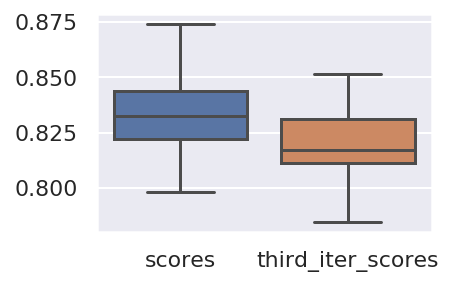

In [23]:
# Read in scores from 3rd iteration
third_iter_scores = np.load('./data/iter03.data.npy')

df = pd.DataFrame(data=list(zip(scores, third_iter_scores)),
                  columns=['scores','third_iter_scores'])
plt.figure(figsize=(3,2), dpi=144)
sns.boxplot(data=df)
plt.savefig(fname='4_vs_3.png', dpi=120);

The median values of one box just barely overlap the color area (IQR) of the other.  Arguably the new model is better.


In [24]:
diff_scores = scores - third_iter_scores
print(np.round(sorted(diff_scores),3))

[0.    0.    0.002 0.009 0.009 0.011 0.011 0.013 0.013 0.016 0.016 0.016
 0.016 0.018 0.02  0.022 0.025 0.025 0.025 0.029]


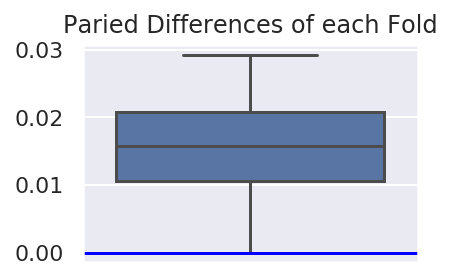

In [25]:
# boxplot the differences and highlight x-axis
plt.figure(figsize=(3,2), dpi=144)
sns.boxplot(y=diff_scores)
plt.title('Paried Differences of each Fold')
plt.axhline(0, color='blue');

In [26]:
# How many times is the new model better?
print(f'New Model wins:  {(diff_scores > 0).sum()}')
print(f'New Model ties:  {(diff_scores == 0).sum()}')
print(f'New Model loses: {(diff_scores < 0).sum()}')

New Model wins:  18
New Model ties:  2
New Model loses: 0


The above shows that the new model is better than the previous model.

In [27]:
# previous model
print(f'Previous Cross Validated Accuracy: {third_iter_scores.mean() :.3f}')

Previous Cross Validated Accuracy: 0.819


### Notebook Summary

In this iteration we:
* looked at the string variables not yet incorporated into the model
* determined that title and Embarked looked promising and encoded them as dummy variables
* compared new model with previous iteration
* simplified the model by removing several extracted features that were not helping

The mean CV score improved from 81.9% in the previous iteration to 83.4% in this iteration.